In [3]:
import numpy as np
import keras

from keras.layers import Dense, GlobalAveragePooling2D

Using TensorFlow backend.


In [0]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')

## Set up data

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
labels = data_obj['target']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.1, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

## Example image

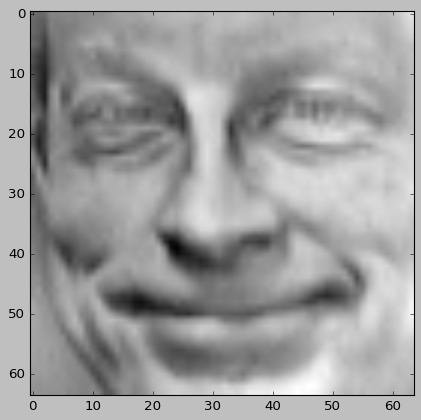

In [8]:
plt.imshow(X_train[0].reshape(64, 64), cmap='gray');

In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


### Variational Autoencoders

Variational Autoencoders (VAE) are a class of generative models.

Unsupervised generative models work with data likelihood, $P(x)$.

VAEs are Bayesian models which use Variational Inference - they work by approximating 

$$ P(x) = \int{P(x|z)P(z) dz} $$

For some random variable $Z$ corresponding to $P(z)$. $Z$ is also called *latent variable*.

VAEs use $Q(z)$ to approximate $P(z)$ - by choosing a simple distribution on latent space - usually Gaussian.

The whole complexity of $P(x)$ is factored out as simple distribution $Q(z)$ and decoder from latent space that is a neural network - it defines $P(x|z)$.


#### Why does it work?

Recall Kullback-Leibler divergence.

$$KL(Q, P(\cdot | X)) = \int Q(z) log \frac{Q(z)}{P(z|x)} dz$$

Rewriting it further $$KL(Q, P(\cdot | X)) =  \int Q(z) log Q(z)dz- \int Q(z) log P(z|x) dz$$

$$ =  \int Q(z) log Q(z)dz - \int Q(z) log \frac{P(x, z)}{P(x)} dz$$

$$ =  \int Q(z) log Q(z)dz - \int Q(z) log P(x, z)dz  + \int Q(z)log P(x)dz $$

$$ = \int Q(z) (log Q(z) - log P(x, z))dz + log P(x)$$

So

$$ log P(x) = KL(Q, P(\cdot | X)) -  \int Q(z) log Q(z)dz + \int Q(z) log P(x, z)dz $$

By noting that the last term is nonnegative we obtain

$$log P(x) \geq KL(Q, P(\cdot | X)) -  \int Q(z) log Q(z)dz $$

This fact is called Variational Lower Bound.

VAEs work by optimizing right hand of this inequality, thus approximately modelling $P(x)$.

In [0]:
def encode(input_img, latent_dim):

    x = layers.Conv2D(32, 3,
                      padding='same', activation='relu')(input_img)
    x = layers.Conv2D(32, 3,
                      padding='same', activation='relu',
                      strides=(2, 2))(x)
    x = layers.Conv2D(32, 3,
                      padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3,
                      padding='same', activation='relu')(x)
    shape_before_flattening = K.int_shape(x)

    x = layers.Flatten()(x)
    code = layers.Dense(16, activation='relu')(x)
    return code, shape_before_flattening

In [0]:
def make_hidden_variable(latent_variable_input):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var) * epsilon
    z_mean = layers.Dense(latent_dim)(latent_variable_input)               
    z_log_var = layers.Dense(latent_dim)(latent_variable_input)

    sampled_hidden = layers.Lambda(sampling)([z_mean, z_log_var])
    return sampled_hidden, z_mean, z_log_var


def make_decoder(z, shape_before_flattening):
    decoder_input = layers.Input(K.int_shape(z)[1:])                

    x = layers.Dense(np.prod(shape_before_flattening[1:]),          
                   activation='relu')(decoder_input)              

    x = layers.Reshape(shape_before_flattening[1:])(x)    
    x = layers.Conv2DTranspose(16, 3,                               
                             padding='same',                      
                             activation='relu',                   
                             strides=(2, 2))(x)

    x = layers.Conv2D(1, 3,                                         
                    padding='same',                               
                    activation='sigmoid')(x)                      

    return Model(decoder_input, x)                               

In [0]:
class VariationalLayer(keras.layers.Layer):
  
    def __init__(self, kl_beta=0.5, reconstruction_loss=keras.metrics.binary_crossentropy, **kwargs):
        self.kl_beta = kl_beta
        self.reconstruction_loss = reconstruction_loss
        super(VariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_reconstructed, z_mean, z_log_var):
        original_dim = np.prod(K.int_shape(x)[1:])
        x = K.flatten(x)
        x_reconstructed = K.flatten(x_reconstructed)
        reconstruction_loss = self.reconstruction_loss(x, x_reconstructed)
        kl_loss = - self.kl_beta / original_dim * K.sum(
            latent_dim + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):                               
        x = inputs[0]
        x_reconstructed = inputs[1]
        z_mean = inputs[2]
        z_log_var = inputs[3]
        loss = self.vae_loss(x, x_reconstructed, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x                                         

In [0]:
def make_vae(input_shape, latent_dim):
    input_img = keras.Input(shape=input_shape)

    code, shape_before_flattening = encode(input_img, latent_dim)
    sampled_hidden, z_mean, z_log_var = make_hidden_variable(code)
    decoder = make_decoder(sampled_hidden, shape_before_flattening)       
    z_decoded = decoder(sampled_hidden)
    y = VariationalLayer(reconstruction_loss=keras.metrics.mean_squared_error)([input_img, z_decoded, z_mean, z_log_var])
    return Model(input_img, y)

In [21]:
img_shape = (64, 64, 1)
batch_size = 16
latent_dim = 32


vae = make_vae(img_shape, latent_dim)

optimizer = keras.optimizers.Adam(beta_1=0.001)
vae.compile(optimizer=optimizer, loss=None)
vae.summary()

X_train = X_train.reshape(-1, *img_shape)
X_test = X_test.reshape(-1, *img_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

In [22]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=100,
        batch_size=8,
        validation_data=(X_test, None),
        callbacks=[early_stopping])

Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 1s 4ms/step - loss: 2.1959 - val_loss: 0.7914
Epoch 2/100
360/360 [==============================] - 1s 2ms/step - loss: 0.8005 - val_loss: 0.7319
Epoch 3/100
360/360 [==============================] - 1s 2ms/step - loss: 0.7654 - val_loss: 0.7304
Epoch 4/100
360/360 [==============================] - 1s 2ms/step - loss: 0.7433 - val_loss: 0.7047
Epoch 5/100
360/360 [==============================] - 1s 2ms/step - loss: 0.7321 - val_loss: 0.6908
Epoch 6/100
360/360 [==============================] - 1s 2ms/step - loss: 0.7233 - val_loss: 0.6832
Epoch 7/100
360/360 [==============================] - 1s 2ms/step - loss: 0.7082 - val_loss: 0.6740
Epoch 8/100
360/360 [==============================] - 1s 2ms/step - loss: 0.6962 - val_loss: 0.6706
Epoch 9/100
360/360 [==============================] - 1s 2ms/step - loss: 0.6878 - val_loss: 0.6525
Epoch 10/100
360/360 [========================

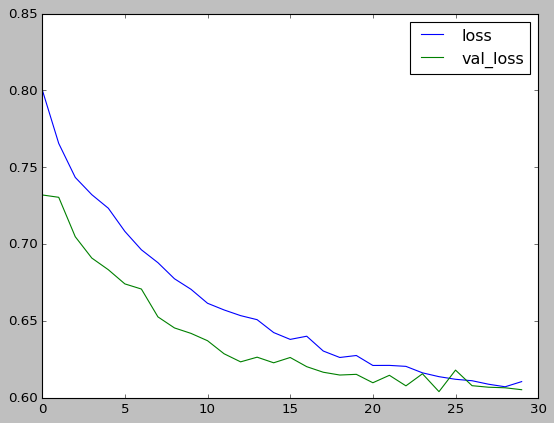

In [23]:
plt.plot(history.history['loss'][1:], label='loss')
plt.plot(history.history['val_loss'][1:], label='val_loss')
plt.legend()
plt.show()

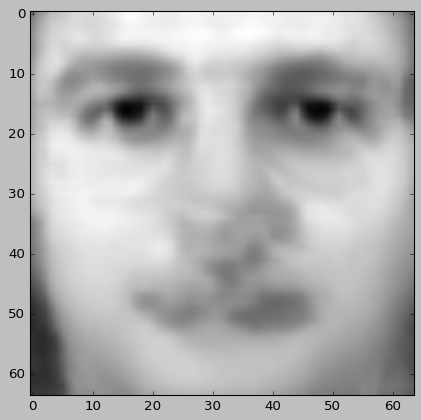

In [24]:
v = np.random.randn(1,latent_dim)
random_image = decoder.predict(v)

plt.imshow(scaler.inverse_transform(random_image[:1, :, :, 0].reshape(1, 4096))[0].reshape((64, 64)), cmap='gray')